In [1]:
import cv2
import torch
import h5py
import numpy as np
import imageio
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import time
from collections import defaultdict

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

/home/rook/.local/share/virtualenvs/sketch2code-rS5pvLAN/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
%reload_ext autoreload

from sketch2code.data_model import *
from sketch2code.datasets import *
from sketch2code.helpers import *
from sketch2code.synthesize_program import *
from sketch2code.visualization import *
from sketch2code.methods.rl_env import *
from sketch2code.methods.dqn import *
from s20_rl_dqn import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#examples 1750
#examples 1250
#examples 250
#examples 250


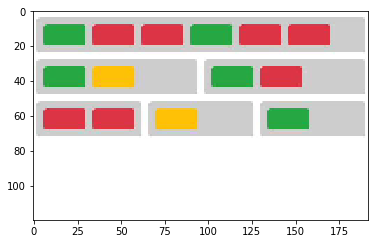

In [4]:
tags, oimages = load_dataset("toy")
print("#examples", len(tags))

def preprocess_img():
    global oimages
    return [shrink_img(img, 0.4, cv2.INTER_NEAREST) for img in norm_rgb_imgs(oimages[:])]

images = cache_object("toy.shrink.imgs.without_transpose", preprocess_img)
plt.imshow(1 - images[0])

vocab, ivocab = make_toy_vocab_v1()
train_examples, valid_examples, test_examples = get_toy_dataset_v1(tags, vocab)

In [5]:
render_engine = RemoteRenderEngine.get_instance(tags[0].to_html(), viewport_width=oimages[0].shape[1], viewport_height=oimages[0].shape[0], full_page=False)

In [6]:
# TODO: uncomment to use GPU
# images = torch.tensor(images, device=device)
torch_images = torch.tensor(images).permute((0, 3, 1, 2))

In [7]:
env_creator = EnvCreator(render_engine, tags, vocab, images, shrink_factor=0.4, interpolation=cv2.INTER_NEAREST, device=device)

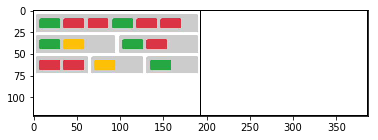

In [8]:
envs = [Env(env_creator, 0)]
plt.imshow(1 - envs[0].render())

In [58]:
env = envs[0]
reward_func = RewardFunc(env.get_target_state())
env.set_reward_func(reward_func.reward, reward_func.max_reward)

# Train DQN

In [70]:
import gym

env = gym.make('CartPole-v0').unwrapped

ModuleNotFoundError: No module named 'gym'

In [56]:
g = Placeholder()
g.MAX_EPS_LEN = 10

g.BATCH_SIZE = 50
g.GAMMA = 0.999
g.EPS_START = 0.9
g.EPS_END = 0.05
g.EPS_DECAY = 10000
g.TARGET_UPDATE = 10  # per eps
g.POLICY_UPDATE = 10  # per actions

g.IMG_REPR_SIZE = 512
g.DSL_EMBED_DIM = 100
g.DSL_HIDDEN_DIM = 512

g.dsl_vocab = env_creator.vocab
g.n_actions = len(env_creator.actions)
print("n_action:", g.n_actions, ", |dsl_vocab|:", len(g.dsl_vocab))

n_action: 12 , |dsl_vocab|: 15


In [57]:
policy_q = DQN(
    EncoderV1(img_h=images[0].shape[0], img_w=images[0].shape[1], img_repr_size=g.IMG_REPR_SIZE), 
    ActionDecoder(g.IMG_REPR_SIZE, dsl_vocab=vocab, dsl_embedding_dim=g.DSL_EMBED_DIM, dsl_hidden_dim=g.DSL_HIDDEN_DIM, n_actions=g.n_actions)).to(device)
target_q = DQN(
    EncoderV1(img_h=images[0].shape[0], img_w=images[0].shape[1], img_repr_size=g.IMG_REPR_SIZE), 
    ActionDecoder(g.IMG_REPR_SIZE, dsl_vocab=vocab, dsl_embedding_dim=g.DSL_EMBED_DIM, dsl_hidden_dim=g.DSL_HIDDEN_DIM, n_actions=g.n_actions)).to(device)
target_q.load_state_dict(policy_q.state_dict())
target_q.eval()

DQN(
  (encoder): EncoderV1(
    (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=12160, out_features=512, bias=True)
  )
  (decoder): ActionDecoder(
    (word_embedding): Embedding(15, 100, padding_idx=0)
    (lstm): LSTMNoEmbedding(
      (lstm): LSTM(612, 512, batch_first=True)
    )
    (lstm2

In [59]:
optimizer = optim.RMSprop(policy_q.parameters())
memory = ReplayMemory(500)

g.step_done = 0
num_episodes = 500
accum_rewards = []
accum_done = []

with tqdm(range(num_episodes), desc='eps') as ebar, tqdm(total=num_episodes * g.MAX_EPS_LEN, desc='actions') as pbar:
    for i_episode in ebar:
        # Initialize the environment and state
        env.reset()
        accum_rewards.append([])
        
        gain_reward = []

        for i in range(g.MAX_EPS_LEN):
            pbar.update()
            obs = env.obs
            action = select_action(policy_q, env_creator, obs, torch_images, g, device)
            next_obs, reward, done, _ = env.step(action)    

            accum_rewards[-1].append(reward)
            gain_reward.append(reward)
            
            # Store the transition in memory
            memory.push(obs, action.action_id, next_obs, reward, not done)

            # Perform one step of the optimization (on the target network)
            loss = optimize_model(policy_q, target_q, optimizer, env_creator, memory, torch_images, g, device)

            if done:
                break
    
        if len(memory.memory) == memory.capacity:
            break
            
        accum_done.append(done)
        ebar.set_postfix(avg_gain=np.mean(gain_reward), reward=env.current_reward)

        # Update the target network, copying all weights and biases in DQN
        if i_episode % g.TARGET_UPDATE == 0:
            target_q.load_state_dict(policy_q.state_dict())

In [ ]:
obs

In [68]:
for obs in memory.memory:
    print(env_creator.actions[obs.action], obs.reward)
#     break
#     print(obs.state.curr_tag.str_tokens, obs.next_state.curr_tag.str_tokens, obs.reward)

AddOpenTagAndClass(<div class="col-12">) 0.0
AddOpenTagAndClass(<div class="col-6">) 0.0
AddOpenTagAndClass(<div class="container-fluid">) 0.0
AddOpenTagAndClass(<button class="btn btn-warning">) 160.0
AddOpenTagAndClass(<div class="col-12">) 0.0
AddOpenTagAndClass(<div class="grey-background">) 0.0
AddOpenTagAndClass(<div class="col-3">) 0.0
AddOpenTagAndClass(<div class="container-fluid">) 0.0
AddOpenTagAndClass(<button class="btn btn-danger">) -26.0
AddOpenTagAndClass(<button class="btn btn-warning">) 0.0
AddOpenTagAndClass(<button class="btn btn-danger">) 166.0
AddOpenTagAndClass(<div class="col-3">) 0.0
AddOpenTagAndClass(<div class="grey-background">) 0.0
AddOpenTagAndClass(<div class="col-6">) 0.0
AddCloseTag() 0
Undo() 0.0
AddOpenTagAndClass(<div class="col-4">) 0.0
AddOpenTagAndClass(<div class="container-fluid">) 0.0
AddOpenTagAndClass(<button class="btn btn-warning">) -26.0
AddOpenTagAndClass(<div class="col-12">) 0.0
AddOpenTagAndClass(<button class="btn btn-success">) 166.

In [64]:
with tqdm(range(100)) as pbar:
    for i in pbar:
        avg_loss = []
        for j in range(20):
            loss = optimize_model(policy_q, target_q, optimizer, env_creator, memory, torch_images, g, device)
            avg_loss.append(float(loss))
        
        pbar.set_postfix(loss=np.mean(avg_loss))
        
    if i % 1 == 0:
        target_q.load_state_dict(policy_q.state_dict())

In [46]:
g.step_done

100

In [15]:
g.EPS_END + (g.EPS_START - g.EPS_END) * math.exp(-1 * g.step_done / g.EPS_DECAY)

0.2799671216792575

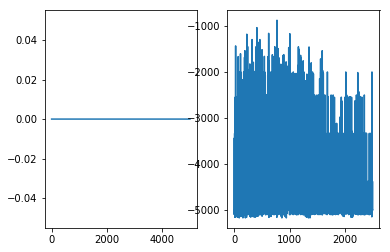

In [16]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(accum_done)
mean_rewards = [np.mean(values) for values in accum_rewards]
ax[1].plot(mean_rewards[::2])
plt.show()

In [15]:
[(i, x) for i, x in enumerate(mean_rewards) if x > 0]

[]

## TEST

TypeError: Invalid dimensions for image data

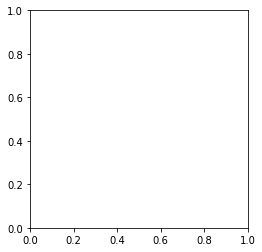

In [24]:
plt.imshow(env.obs.goal_state)

In [17]:
print(g.n_actions, len(env_creator.actions))

11 11


In [18]:
env.obs.curr_tag.to_body()

'<button class="btn btn-warning"></button>'

In [19]:
[(env_creator.actions[i.action], i.reward) for i in memory.memory]

[(AddCloseTag(), -5000),
 (AddCloseTag(), -5000),
 (AddCloseTag(), -5000),
 (AddCloseTag(), -5000),
 (AddCloseTag(), -5000),
 (AddCloseTag(), -5000),
 (AddOpenTagAndClass(<button class="btn btn-warning">), -5198),
 (AddOpenTagAndClass(<button class="btn btn-danger">), -5097),
 (AddCloseTag(), -5000),
 (AddOpenTagAndClass(<div class="col-4">), -5000),
 (AddOpenTagAndClass(<button class="btn btn-danger">), -5162),
 (AddOpenTagAndClass(<div class="col-6">), -5000),
 (AddCloseTag(), -5000),
 (AddCloseTag(), -5000),
 (AddCloseTag(), -5000),
 (AddOpenTagAndClass(<button class="btn btn-warning">), -5198),
 (AddCloseTag(), -5000),
 (AddCloseTag(), -5000),
 (AddCloseTag(), -5000),
 (AddOpenTagAndClass(<div class="container-fluid">), 0),
 (AddCloseTag(), 0),
 (AddOpenTagAndClass(<div class="container-fluid">), 0),
 (AddOpenTagAndClass(<div class="container-fluid">), -5000),
 (AddCloseTag(), -5000),
 (AddCloseTag(), -5000),
 (AddCloseTag(), -5000),
 (AddCloseTag(), -5000),
 (AddOpenTagAndClass(<d

take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000


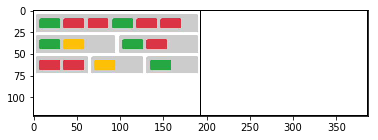

In [22]:
env.reset()
for i in range(g.MAX_EPS_LEN):
    action = select_action(policy_q, env_creator, env.obs, g, device, eps_threshold=0.05)
    next_obs, reward, _, _ = env.step(action)
    print('take action:', action, 'reward', reward)
    if i > 20:
        break
plt.imshow(1 - env.render())

## DEBUG

In [17]:
env.reset()

In [19]:
action = select_action(policy_q, env_creator, env.obs, g, device)
print(action)
print(env.step(action)[0].curr_tag.to_body())

AddOpenTag(<div>)
<div></div>


In [ ]:
plt.imshow(1 - env.render())

In [ ]:
print(env.obs.curr_tag.to_body())
print(env.obs.curr_tag.str_tokens)
print(env.obs.curr_tag.tokens)